In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [29]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/covid_19_clean_complete.csv')
print("Initial Data Overview:")
print(data.head())

Initial Data Overview:
  Province/State Country/Region       Lat       Long        Date  Confirmed  \
0            NaN    Afghanistan  33.93911  67.709953  2020-01-22          0   
1            NaN        Albania  41.15330  20.168300  2020-01-22          0   
2            NaN        Algeria  28.03390   1.659600  2020-01-22          0   
3            NaN        Andorra  42.50630   1.521800  2020-01-22          0   
4            NaN         Angola -11.20270  17.873900  2020-01-22          0   

   Deaths  Recovered  Active             WHO Region  
0       0          0       0  Eastern Mediterranean  
1       0          0       0                 Europe  
2       0          0       0                 Africa  
3       0          0       0                 Europe  
4       0          0       0                 Africa  


In [30]:
# Filter data for the US (or any specific country)
data_us = data[data['Country/Region'] == 'US'].copy()

# Convert Date column to datetime
data_us['Date'] = pd.to_datetime(data_us['Date'])

# Feature Engineering: Extract date-based features
data_us['DayOfYear'] = data_us['Date'].dt.dayofyear
data_us['Month'] = data_us['Date'].dt.month
data_us['Weekday'] = data_us['Date'].dt.weekday

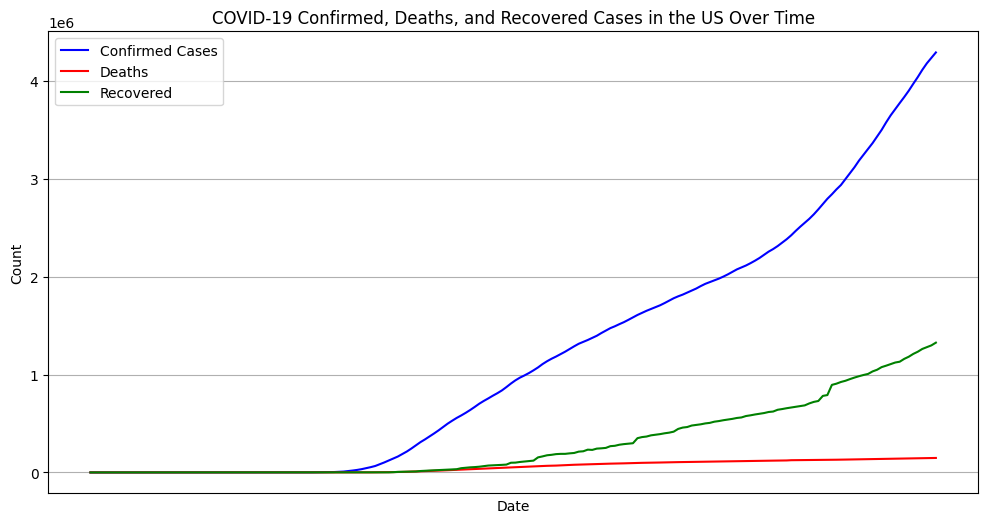

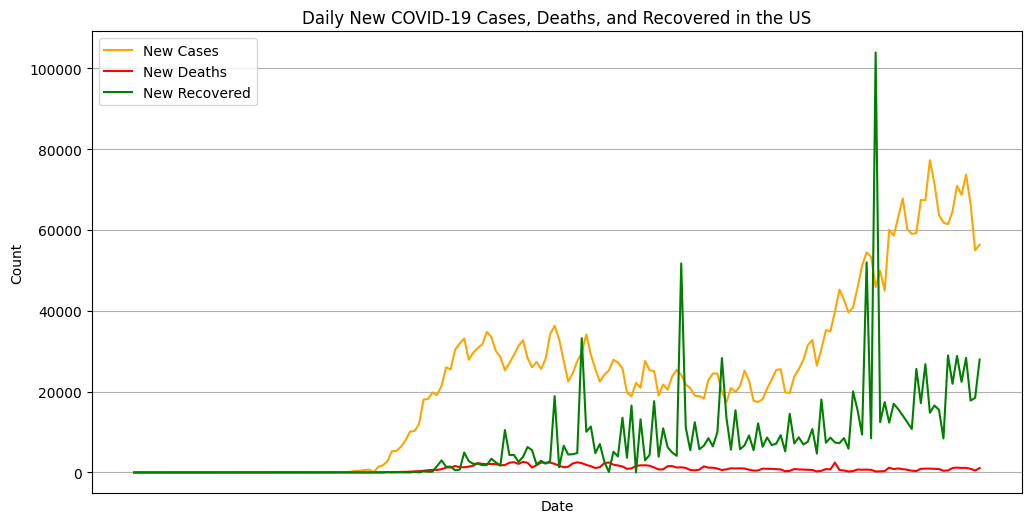

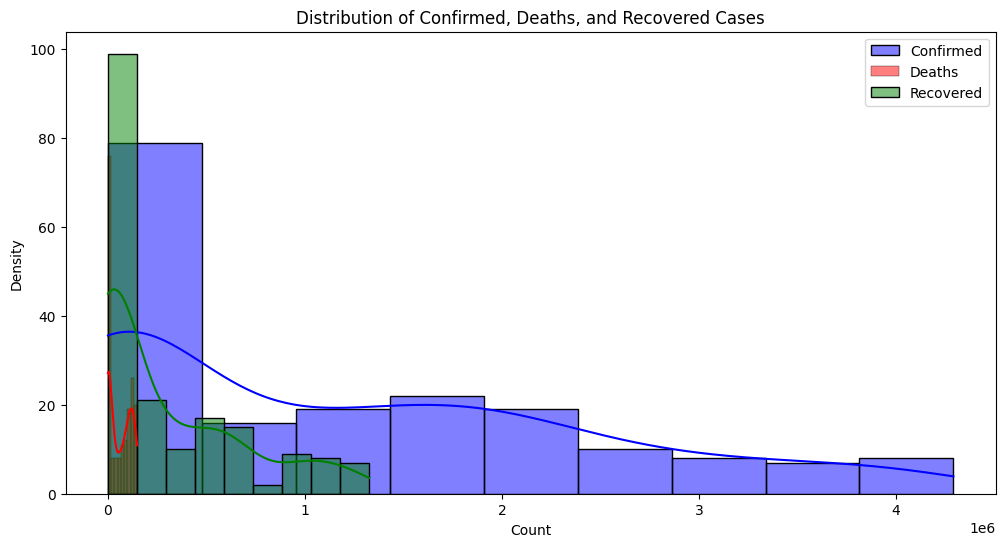

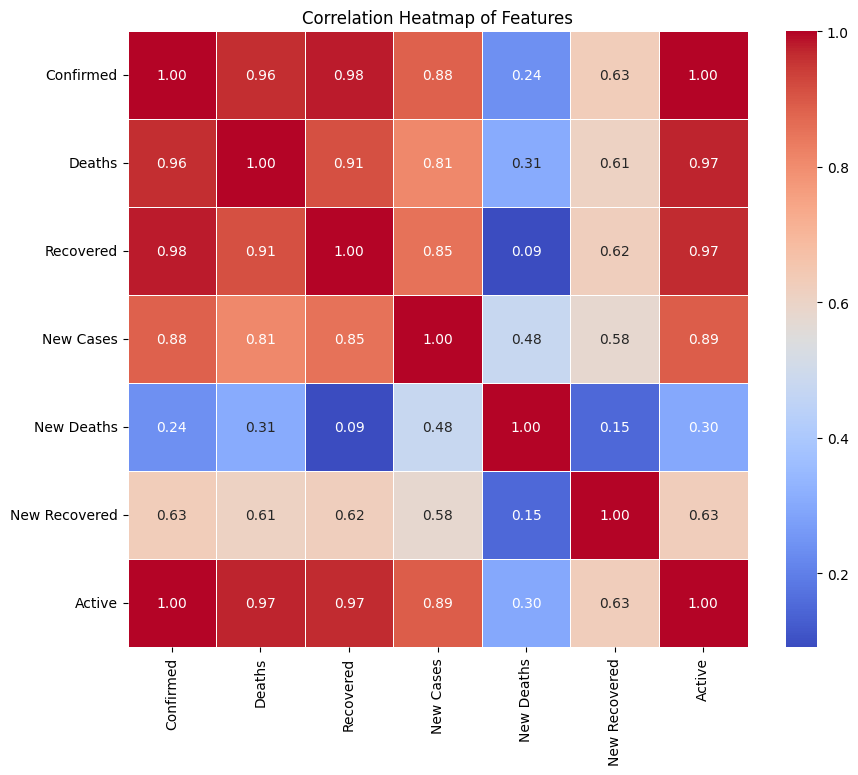

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates



# --- EDA Plot 1: Time Series Plot ---
plt.figure(figsize=(12, 6))
plt.plot(data_us['Date'], data_us['Confirmed'], label='Confirmed Cases', color='blue')
plt.plot(data_us['Date'], data_us['Deaths'], label='Deaths', color='red')
plt.plot(data_us['Date'], data_us['Recovered'], label='Recovered', color='green')

# Formatting x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Show year labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as "YYYY"
plt.xticks(rotation=45)

plt.title('COVID-19 Confirmed, Deaths, and Recovered Cases in the US Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

# --- EDA Plot 2: Daily New Cases, Deaths, and Recovered ---
data_us['New Cases'] = data_us['Confirmed'].diff().fillna(0).clip(lower=0)
data_us['New Deaths'] = data_us['Deaths'].diff().fillna(0).clip(lower=0)
data_us['New Recovered'] = data_us['Recovered'].diff().fillna(0).clip(lower=0)

plt.figure(figsize=(12, 6))
plt.plot(data_us['Date'], data_us['New Cases'], label='New Cases', color='orange')
plt.plot(data_us['Date'], data_us['New Deaths'], label='New Deaths', color='red')
plt.plot(data_us['Date'], data_us['New Recovered'], label='New Recovered', color='green')

# Formatting x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.title('Daily New COVID-19 Cases, Deaths, and Recovered in the US')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

# EDA Plot 3: Distribution of Confirmed Cases, Deaths, and Recovered cases
plt.figure(figsize=(12, 6))
sns.histplot(data_us['Confirmed'], kde=True, color='blue', label='Confirmed')
sns.histplot(data_us['Deaths'], kde=True, color='red', label='Deaths')
sns.histplot(data_us['Recovered'], kde=True, color='green', label='Recovered')
plt.title('Distribution of Confirmed, Deaths, and Recovered Cases')
plt.xlabel('Count')
plt.ylabel('Density')
plt.legend()
plt.show()

# EDA Plot 4: Correlation Heatmap of the Features
correlation_matrix = data_us[['Confirmed', 'Deaths', 'Recovered', 'New Cases', 'New Deaths', 'New Recovered', 'Active']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

In [33]:
# Calculate daily new cases, deaths, and recovered
data_us['New Cases'] = data_us['Confirmed'].diff().fillna(0).clip(lower=0)
data_us['New Deaths'] = data_us['Deaths'].diff().fillna(0).clip(lower=0)
data_us['New Recovered'] = data_us['Recovered'].diff().fillna(0).clip(lower=0)

# Calculate 7-day rolling averages for confirmed cases and deaths
data_us['Confirmed_7day_Avg'] = data_us['Confirmed'].rolling(window=7).mean().fillna(0)
data_us['Deaths_7day_Avg'] = data_us['Deaths'].rolling(window=7).mean().fillna(0)

In [34]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
# Define features and target variable
X = data_us[['New Cases', 'New Deaths', 'Recovered', 'Confirmed_7day_Avg', 'Active', 'DayOfYear', 'Month', 'Weekday']]
y = data_us['Confirmed']

# Handle missing values in features and target variable
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameters for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

# Hyperparameters for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15]
}

# Initialize the models
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
lr_model = LinearRegression()

# Perform GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=3)
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_

# Perform GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=3)
grid_search_xgb.fit(X_train, y_train)
best_xgb_model = grid_search_xgb.best_estimator_

# Train the Linear Regression model
lr_model.fit(X_train, y_train)

# Predict and evaluate Random Forest model
y_pred_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Predict and evaluate XGBoost model
y_pred_xgb = best_xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Predict and evaluate Linear Regression model
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

# Calculate accuracy (for historical predictions on test data) for all models
accuracy_rf = 1 - (mse_rf / np.var(y_test))
accuracy_xgb = 1 - (mse_xgb / np.var(y_test))
accuracy_lr = 1 - (mse_lr / np.var(y_test))

# Display model performance metrics
print("\nRandom Forest Model with Hyperparameter Tuning:")
print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"R-squared (R2): {r2_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Regression Accuracy (on historical test data): {accuracy_rf * 100:.2f}%")

print("\nXGBoost Model with Hyperparameter Tuning:")
print(f"Best Parameters: {grid_search_xgb.best_params_}")
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"R-squared (R2): {r2_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Regression Accuracy (on historical test data): {accuracy_xgb * 100:.2f}%")

print("\nLinear Regression Model:")
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"R-squared (R2): {r2_lr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"Regression Accuracy (on historical test data): {accuracy_lr * 100:.2f}%")

# Function to predict future confirmed cases for all models
def predict_future_cases(model, latest_data, future_days=7):
    future_predictions = []
    current_data = latest_data.copy()

    for _ in range(future_days):
        prediction = model.predict(current_data)
        future_predictions.append(prediction[0])

        # Add predicted value as a new feature for next prediction (recursive prediction)
        current_data = np.append(current_data[:, 1:], [[prediction[0]]], axis=1)

    return future_predictions

# Use the last row of the dataset for the most recent data (last day)
latest_data = X.iloc[-1].values.reshape(1, -1)

# Predict the next 7 days (future confirmed cases) using all models
print("\nFuture Confirmed Cases Predictions (Next 7 days):")

# XGBoost Future Predictions
future_predictions_xgb = predict_future_cases(best_xgb_model, latest_data, future_days=7)
for i, prediction in enumerate(future_predictions_xgb, 1):
    print(f"XGBoost - Day {i}: {prediction:.0f}")

# Random Forest Future Predictions
future_predictions_rf = predict_future_cases(best_rf_model, latest_data, future_days=7)
for i, prediction in enumerate(future_predictions_rf, 1):
    print(f"Random Forest - Day {i}: {prediction:.0f}")

# Linear Regression Future Predictions
future_predictions_lr = predict_future_cases(lr_model, latest_data, future_days=7)
for i, prediction in enumerate(future_predictions_lr, 1):
    print(f"Linear Regression - Day {i}: {prediction:.0f}")

<ipython-input-34-e01bbda7deb5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)



Random Forest Model with Hyperparameter Tuning:
Best Parameters: {'max_depth': 10, 'n_estimators': 300}
Mean Squared Error (MSE): 442375201.27
R-squared (R2): 0.9997
Mean Absolute Error (MAE): 10858.45
Regression Accuracy (on historical test data): 99.97%

XGBoost Model with Hyperparameter Tuning:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}
Mean Squared Error (MSE): 3093390080.00
R-squared (R2): 0.9981
Mean Absolute Error (MAE): 32789.63
Regression Accuracy (on historical test data): 99.81%

Linear Regression Model:
Mean Squared Error (MSE): 14733192.52
R-squared (R2): 1.0000
Mean Absolute Error (MAE): 2902.79
Regression Accuracy (on historical test data): 100.00%

Future Confirmed Cases Predictions (Next 7 days):
XGBoost - Day 1: 4290254
XGBoost - Day 2: 3543114
XGBoost - Day 3: 4242616
XGBoost - Day 4: 330927
XGBoost - Day 5: 246907
XGBoost - Day 6: 2499
XGBoost - Day 7: 3533149
Random Forest - Day 1: 4223413
Random Forest - Day 2: 1557167
Random Fo

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

<ipython-input-35-a3de48a73924>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="MSE", data=metrics_df, palette="Blues_d")
<ipython-input-35-a3de48a73924>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R²", data=metrics_df, palette="Greens_d")
<ipython-input-35-a3de48a73924>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="MAE", data=metrics_df, palette="Reds_d")


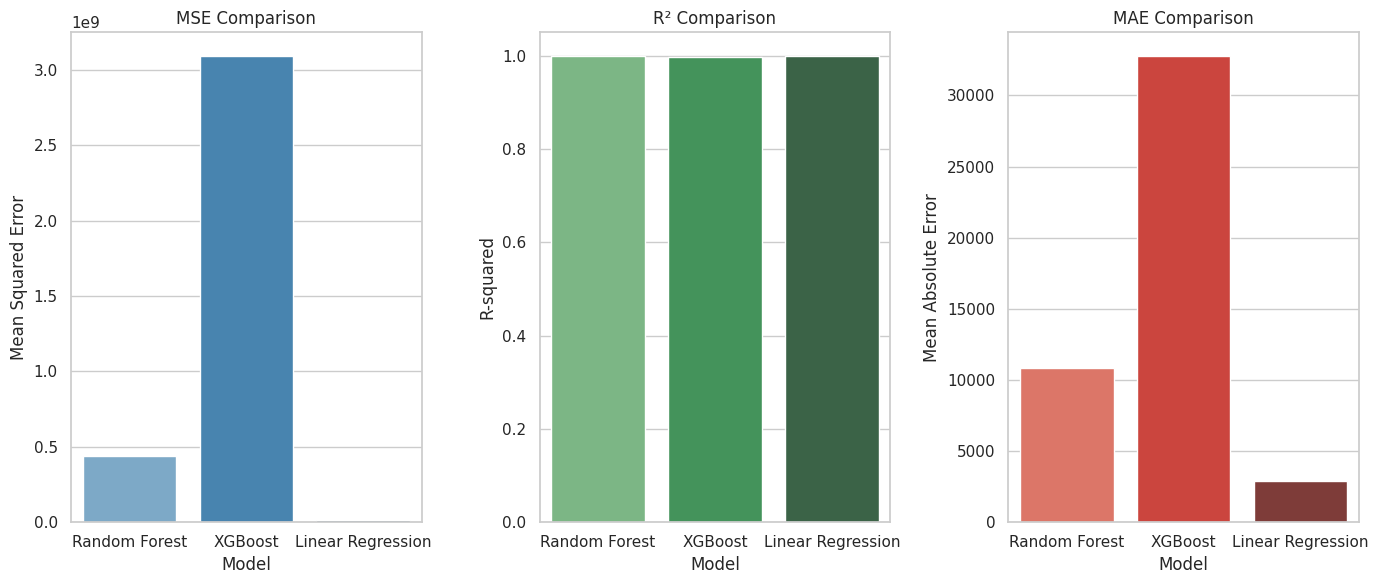

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Store model performance metrics
metrics = {
    "Model": ["Random Forest", "XGBoost", "Linear Regression"],
    "MSE": [mse_rf, mse_xgb, mse_lr],
    "R²": [r2_rf, r2_xgb, r2_lr],
    "MAE": [mae_rf, mae_xgb, mae_lr]
}

# Convert the metrics to a DataFrame for easy plotting
metrics_df = pd.DataFrame(metrics)

# Set up the figure size and style
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

# Plot MSE comparison
plt.subplot(1, 3, 1)
sns.barplot(x="Model", y="MSE", data=metrics_df, palette="Blues_d")
plt.title("MSE Comparison")
plt.ylabel("Mean Squared Error")

# Plot R² comparison
plt.subplot(1, 3, 2)
sns.barplot(x="Model", y="R²", data=metrics_df, palette="Greens_d")
plt.title("R² Comparison")
plt.ylabel("R-squared")

# Plot MAE comparison
plt.subplot(1, 3, 3)
sns.barplot(x="Model", y="MAE", data=metrics_df, palette="Reds_d")
plt.title("MAE Comparison")
plt.ylabel("Mean Absolute Error")

# Display the comparison graphs
plt.tight_layout()
plt.show()